# Spark Structured Streaming Basics

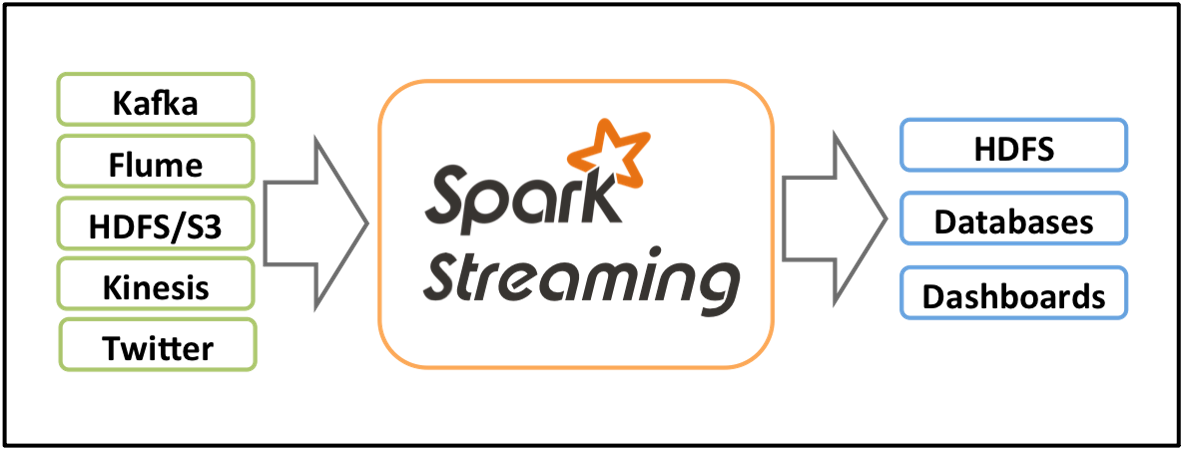

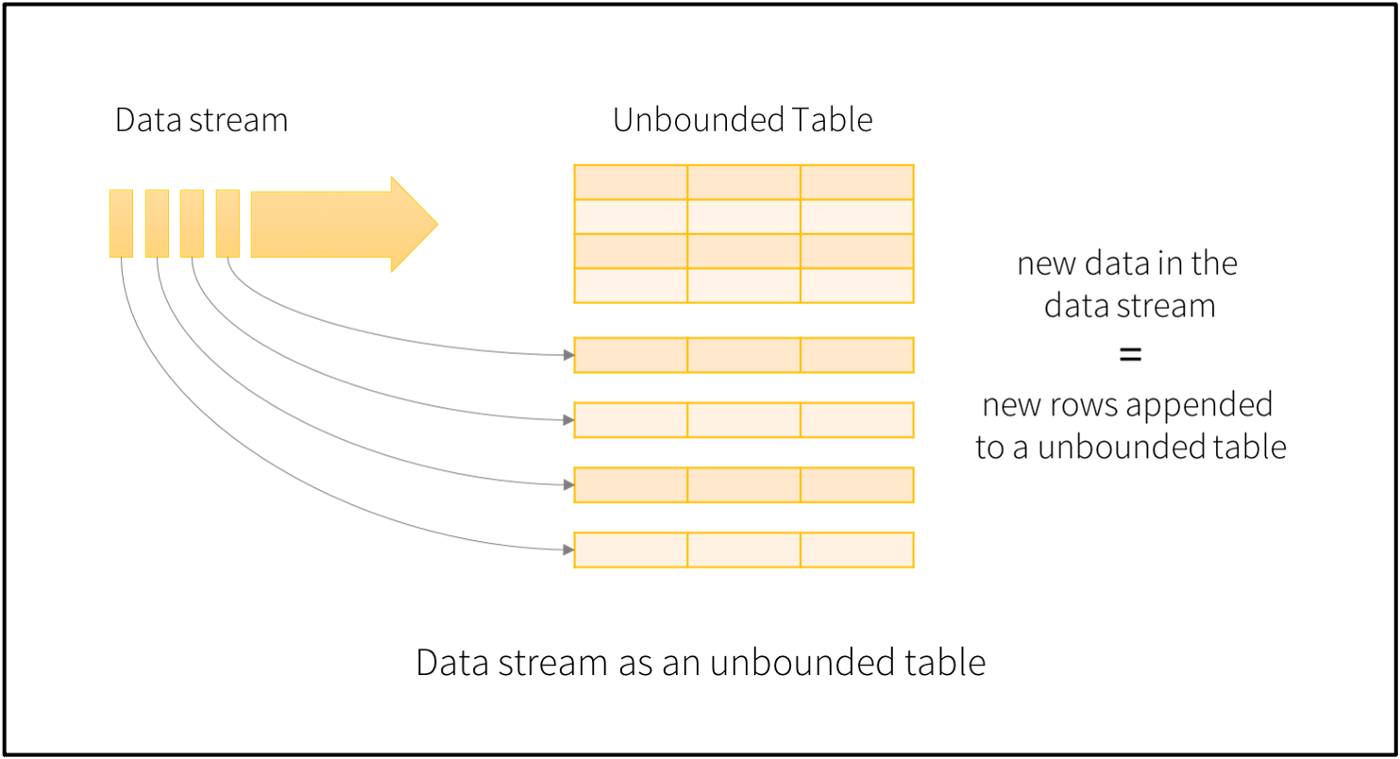

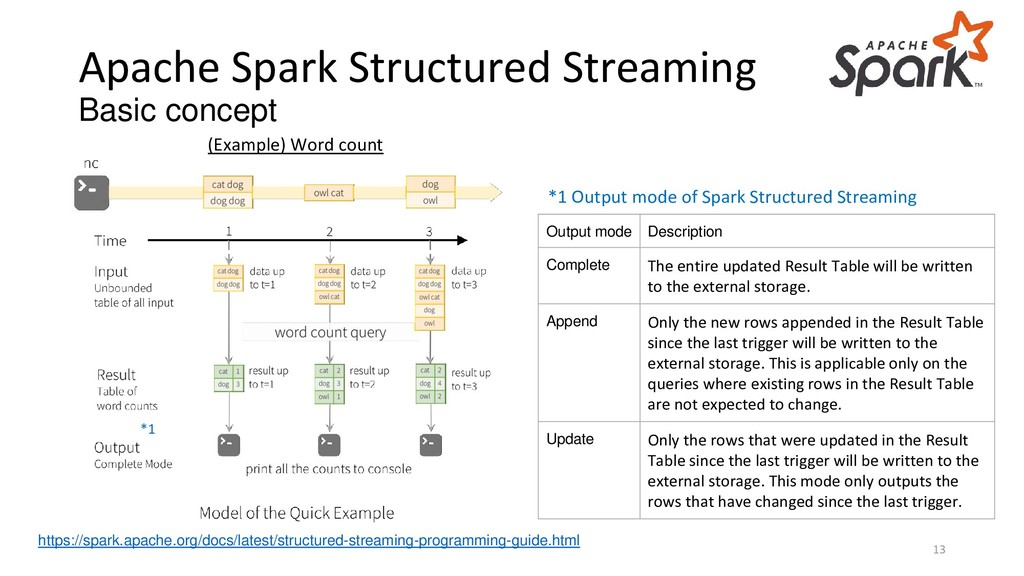

## Structured Streaming In Theory

Structured Streaming is designed to make it easy to build end-to-end continuous applications using Apache Spark that combine streaming, batch, and interactive queries. For example, Structured Streaming does not use a separate API from DataFrames: you simply write a normal DataFrame (or SQL) computation and launch it on a stream. Structured Streaming will automatically update the result of this computation in an incremental fashion as data arrives.

## Transformations and Actions

Structured Streaming maintains the same concept of transformations and actions that we have seen throughout this semester. The transformations available in Structured Streaming are, with a fewrestrictions, the exact same transformations that we saw before. The restrictions usually involve some types of queries that the engine cannot incrementalize.

## Input Sources

Structured Streaming supports several input sources for reading in a streaming fashion, for example: Apache Kafka, HDFS.

## Sinks

Just as sources allow you to get data into Structured Streaming, sinks specify the destination for the result set of that stream, for example: Apache Kafka, Almost any file format.

## Triggers

Whereas output modes define how data is output, triggers define when data is output. In simple words: when Structured Streaming should check for new input data and update its result. By default,Structured Streaming will look for new input records as soon as it has finished processing the last group of input data, giving the lowest latency possible for new results. However, this behavior can lead to writing many small output files when the sink is a set of files. Thus, Spark also supports triggers based on processing time (only look for new data at a fixed interval).

By setting processing time triger, data will be processed at intervals according to the trigger. If a trigger is missed because the previous processing has not yet been completed, Spark will skip this processing point, the next processing will be done at the next point and so on.

## Event-Time Processing

Event-time means time fields that are embedded in your data. This means that rather than processing data according to the time it reaches your system, you process it according to the timethat it was generated, even if records arrive out of order at the streaming application due to slow uploads or network delays. Simple in Structured Streaming as the system views the input data as a table. However, under the hood, Structured Streaming can take some special actions when it knows that one of your columns is an event-time field, including optimizing query execution or determining when it is safe to forget state about a time window.

# Structured Streaming in Action

In [9]:
%cd "C:\Users\uriah\OneDrive\Desktop\Distributed Information Management/PROJECT/PROJECT PART 2/Colab Locals"

C:\Users\uriah\OneDrive\Desktop\Distributed Information Management\PROJECT\PROJECT PART 2\Colab Locals


In [ ]:
!python -m venv .venv

In [ ]:
!pip uninstall matplotlib

In [27]:
!.venv\Scripts\activate
!pip install matplotlib --target .venv\Lib\site-packages
!.venv\Scripts\deactivate

  Using cached matplotlib-3.5.3-cp310-cp310-win_amd64.whl (7.2 MB)
     ------------------------------------ 950.4/950.4 kB 395.9 kB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached Pillow-9.2.0-cp310-cp310-win_amd64.whl (3.3 MB)
  Using cached numpy-1.23.2-cp310-cp310-win_amd64.whl (14.6 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-win_amd64.whl (55 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlfromscratch 0.0.4 requires cvxopt, which is not installed.
gym 0.25.0 requires cloudpickle>=1.2.0, which is not installed.
gym 0.25.0 requires gym_notices>=0.0.4, which is not installed.


In [26]:
import pandas as pd

In [ ]:
!pip install findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import time
import os

def init_spark(app_name: str):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc

spark, sc = init_spark('demo')
print(spark.version)
print('CPUs:', os.cpu_count())

ModuleNotFoundError: ignored

# Dataset

Heterogeneity Human Activity Recognition Dataset - the data consists of smartphone and smartwatch sensor readings from a variety of devices.

In [ ]:
!unzip /content/activity-data.zip -d /content/

Archive:  /content/activity-data.zip
   creating: /content/activity-data/
  inflating: /content/activity-data/part-00000-tid-730451297822678341-1dda7027-2071-4d73-a0e2-7fb6a91e1d1f-0-c000.json  
  inflating: /content/activity-data/part-00001-tid-730451297822678341-1dda7027-2071-4d73-a0e2-7fb6a91e1d1f-0-c000.json  
  inflating: /content/activity-data/part-00002-tid-730451297822678341-1dda7027-2071-4d73-a0e2-7fb6a91e1d1f-0-c000.json  
  inflating: /content/activity-data/part-00003-tid-730451297822678341-1dda7027-2071-4d73-a0e2-7fb6a91e1d1f-0-c000.json  
  inflating: /content/activity-data/part-00004-tid-730451297822678341-1dda7027-2071-4d73-a0e2-7fb6a91e1d1f-0-c000.json  
  inflating: /content/activity-data/part-00005-tid-730451297822678341-1dda7027-2071-4d73-a0e2-7fb6a91e1d1f-0-c000.json  


In [ ]:
static = spark.read.json("activity-data/")
static.printSchema()
static.show(3)
print(f"Loaded {static.count()} Rows and {len(static.columns)} Columns.")

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

+-------------+-------------------+--------+-----+------+----+-----+------------+-----------+-------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|           x|          y|            z|
+-------------+-------------------+--------+-----+------+----+-----+------------+-----------+-------------+
|1424686734964|1424688581018556031|nexus4_2|    1|nexus4|   g|stand|-0.001449585|0.035491943|  0.027999878|
|1424686735180|1424688581235108765|nexus4_2|   44|nexus4|   g|stand|-0.006790161|-0.05102539|  0.020523071|
|1424686735384|1424688581436677369|nexus4_2|   84|nexus4|   g|stand| 6.866455E-4| 0.016265

Next, let’s create a streaming version of the same Dataset, which will read each input file in the dataset one by one as if it was a stream.

### Building Preprocessing Pipeline

In [ ]:
import pyspark.sql.functions as f
from pyspark.ml.feature import VectorAssembler, VectorSizeHint, OneHotEncoder, StringIndexer, IndexToString, SQLTransformer, Interaction, UnivariateFeatureSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
original_features = ['Arrival_Time', 'Creation_Time', 'Device', 'User', 'x', 'y', 'z', 'gt']
features = ['Arrival_Time', 'Creation_Time', 'DeviceIndex', 'userIndex', 'x', 'y', 'z']
f_statement = str(original_features).strip("[]").replace("'", "")

feature_interactions_names = [str(f1+' '+f2)
                              for i, f1 in enumerate(features) 
                              for j, f2 in enumerate(features) 
                              if i < j]

features_to_remove = ['Arrival_Time Creation_Time', 'Creation_Time userIndex', 'Arrival_Time x', 
                      'userIndex x', 'Creation_Time x', 'x z', 'DeviceIndex x', 'DeviceIndex z']
for feature in features_to_remove:
    feature_interactions_names.remove(feature)

feature_interactions = [Interaction(inputCols=s.split(sep=' '), 
                                    outputCol=s)
                        for s in feature_interactions_names]

final_features = [*features, *feature_interactions_names]

preprocessing_pipeline = Pipeline(stages=[
    SQLTransformer(statement=f"SELECT {f_statement} FROM __THIS__"),
    StringIndexer(inputCol="gt", outputCol="label", handleInvalid="keep"),
    StringIndexer(inputCol="Device", outputCol="DeviceIndex", handleInvalid="keep"),
    StringIndexer(inputCol="User", outputCol="userIndex", handleInvalid="keep"),
    SQLTransformer(
        statement=f"SELECT {f_statement}, (DeviceIndex + 1) AS DeviceIndex, (userIndex + 1) AS userIndex, (label + 1) AS label FROM __THIS__"),
    *feature_interactions,
    VectorAssembler(inputCols=final_features,
                    outputCol='features'),
    VectorSizeHint(inputCol='features', 
                    size=len(final_features), 
                    handleInvalid='optimistic'),
    SQLTransformer(statement=f"SELECT {f_statement}, features, label FROM __THIS__")])

In [ ]:
len(final_features)

20

In [ ]:
learning_pipeline = RandomForestClassifier(numTrees=15, 
                                           maxDepth=10)

In [ ]:
train, test = static.randomSplit([0.3, 0.7])
pipeline = Pipeline(stages=[preprocessing_pipeline, learning_pipeline])
model_pipeline = pipeline.fit(train)

In [ ]:
model_pipeline.save("/content/saved_model")

In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

In [ ]:
evaluator = MulticlassClassificationEvaluator()

### Streaming On Data

In [ ]:
streaming = spark \
    .readStream \
    .schema(static.schema) \
    .option("maxFilesPerTrigger", 1) \
    .outputMode("append") \
    .json("activity-data/")

print("Starting Streaming...")
# create a query that reads all the data and saves it to memory sink
streamQuery = streaming.writeStream \
                        .format("memory") \
                        .queryName("sink") \
                        .start()

# let the stream run for a while first so that the table gets populated
snapshot = spark.sql("select * from sink")

while len(snapshot.head(1)) == 0:
    time.sleep(5)
    snapshot = spark.sql("select * from sink")

# after there is data to read, give initial, arbitrary prediction and report accuracy
print("Initial Evaluation:")
eval = evaluator.evaluate(snapshot.withColumn("prediction", f.lit(1)).withColumn("label", f.col("gt")))
print(f"Accuracy: {eval}")

# now give model initial training on the data we predicted
print("Initial Training...")
snapshot = snapshot.select(*original_features)
model = pipeline.fit(snapshot)

# every 5 seconds scan for new arrived data, predict and report accuracy and then fit model on the predicted data.
# do this until no new data arrives for a sufficient amount of time, then stop streaming.

n_loaded = snapshot.count()  # total number of rows loaded so far
epoch_id = 0  # iteration/batch/streaming epoch.
cold_streams = 0  # cold stream = stream where no new data arrived
termination_buffer = 3  # terminate after "termination_buffer" cold streams
while cold_streams < termination_buffer:

    snapshot = spark.sql("select * from sink")
    n_current = snapshot.count()

    if n_current == n_loaded:
        cold_streams += 1
        time.sleep(5)
        continue
    else:
        n_loaded = n_current

        print("==" * 20)
        print(f"Batch: {epoch_id}")
        print("==" * 20)

        print("predicting...")
        snapshot = model.transform(snapshot)

        print("evaluating...")
        print(f"Accuracy: {evaluator.evaluate(snapshot)}")

        print("training model...")
        snapshot = snapshot.select(*original_features)
        model = pipeline.fit(snapshot)

        epoch_id += 1
        time.sleep(5)

print("ending stream...")
streamQuery.stop()

transformedStream is of type: <class 'pyspark.sql.dataframe.DataFrame'>
Starting Streaming...
transformedStream is of type: <class 'pyspark.sql.dataframe.DataFrame'>
Batch: 1
evaluating...
Accuracy: 0.618935764162393
training model...


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 540, in send_command
    "Error while sending or receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: ignored

In [ ]:
query.stop()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 540, in send_command
    "Error while sending or receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: ignored

In [ ]:
streaming = spark \
    .readStream \
    .schema(static.schema) \
    .option("maxFilesPerTrigger", 1) \
    .json("activity-data/")

no_process = streaming \
    .writeStream \
    .queryName("no_process") \
    .format("memory") \
    .outputMode("append") \
    .start()

# i = 0
# while i in range(5):
#     batch = spark.sql("SELECT * FROM no_process")
#     batch.persist()

#     if len(batch.head(1)) > 0:
#         print("==" * 20)
#         print(f"Batch: {i}")
#         print("==" * 20)
#         predictionsDF = model_pipeline.transform(batch)
#         print(f"Accuracy: {evaluator.evaluate(predictionsDF)}")
#         model_pipeline = pipeline.fit(batch)
#         print()
#         i += 1
#     else:
#         time.sleep(5)
    
#     batch.unpersist()

no_process.stop()

In [ ]:

def foreach_batch_function(batch, epoch_id, model=model_pipeline):
    # Transform and write batchDF
    pass

process = streaming \
    .writeStream \
    .format("memory") \
    .queryName("process") \
    .start()
i=0
while i<10:
    time.sleep(2)
    batch = spark.sql("SELECT * FROM process")
    batch.persist()
    if len(batch.head(1)) > 0:
        print("==" * 20)
        print(f"Batch: {i}")
        print("==" * 20)
        predictionsDF = model_pipeline.transform(batch)
        print(f"Accuracy: {evaluator.evaluate(predictionsDF)}")
        model_pipeline = pipeline.fit(batch)
        print()
    else:
        time.sleep(5)
    
    batch.unpersist()
    i+=1
process.stop()

Batch: 1
Accuracy: 0.6084553022195918

Batch: 2
Accuracy: 0.6220452554104653

Batch: 3
Accuracy: 0.6211795329178408


Py4JJavaError: ignored

In [ ]:
process.stop()

### Rest Of Tutorial

In [ ]:
streamingQuery = streaming\
                .writeStream\
                .queryName("no_process")\
                .format("memory")\
                .outputMode("append")\
                .start()

In [ ]:
print("Query Last Progress:")
print(type(streamingQuery.lastProgress))
for k, v in streamingQuery.lastProgress.items():
    print(f"{k}: {v}")
print("--"*10)

print("Current Query Status:")
for k, v in streamingQuery.status.items():
    print(f"{k}: {v}")
print("--"*10)

streamingQuery.stop()

In [ ]:
streamingQuery.stop()

In [ ]:
# this is a df but doesn't hold anything as it's lazy
activityCounts = streaming.groupBy("gt").count()

# however, calling an action will result with an error as Queries with streaming sources must be executed with writeStream.start()

In [ ]:
# avoid creating too many shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", 2)

In [ ]:
# Streaming Query
# Here the output is written to a memory sink which keeps an in-memory table of the results.
# Here we use the complete output mode - this mode rewrites all of the keys along with their counts after every trigger
activityQuery = activityCounts\
    .writeStream\
    .queryName("activity_counts")\
    .format("memory")\
    .outputMode("complete")\
    .start()

In [ ]:
# our streaming is active
# streaming computation has started in the background
spark.streams.active

In [ ]:
from time import sleep
for x in range(5):
    spark.sql("SELECT * FROM activity_counts").show()
    sleep(2)

activityQuery.stop()

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|24620|
|      walk|26512|
|  stairsup|20905|
|      bike|21594|
|     stand|22770|
|      null|20894|
|stairsdown|18729|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|36929|
|      walk|39768|
|  stairsup|31357|
|      bike|32390|
|     stand|34154|
|      null|31343|
|stairsdown|28094|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|61546|
|      walk|66280|
|  stairsup|52259|
|      bike|53984|
|     stand|56924|
|      null|52240|
|stairsdown|46826|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|73855|
|      walk|79536|
|  stairsup|62710|
|      bike|64781|
|     stand|68309|
|      null|62688|
|stairsdown|56192|
+----------+-----+

+----------+-----+
|        gt|count|
+----------+-----+
|       sit|73855|
|      walk|79536|
|  stairsup|62710|
|      bike|64781|
|     stand|68309|
|      n

# Transformations on Streams

## Selections and Filtering

In [ ]:
from pyspark.sql.functions import expr

simpleTransform = streaming\
    .withColumn("stairs",expr("gt like '%stairs%'"))\
    .where("stairs")\
    .where("gt is not null")\
    .select("gt","model","arrival_time","creation_time")\
    .writeStream\
    .queryName("simple_transform")\
    .format("memory")\
    .outputMode("append")\
    .start()

for x in range(3):
    spark.sql("SELECT * FROM simple_transform").show()
    sleep(2)

simpleTransform.stop()

+---+-----+------------+-------------+
| gt|model|arrival_time|creation_time|
+---+-----+------------+-------------+
+---+-----+------------+-------------+

+--------+------+-------------+-------------------+
|      gt| model| arrival_time|      creation_time|
+--------+------+-------------+-------------------+
|stairsup|nexus4|1424687983725|1424689829780924966|
|stairsup|nexus4|1424687984011|1424687982020381820|
|stairsup|nexus4|1424687984413|1424687982421559529|
|stairsup|nexus4|1424687984818|1424687982827412800|
|stairsup|nexus4|1424687985223|1424687983227571661|
|stairsup|nexus4|1424687985623|1424687983630373175|
|stairsup|nexus4|1424687986026|1424687984033235724|
|stairsup|nexus4|1424687986428|1424687984435884650|
|stairsup|nexus4|1424687986833|1424687984840816323|
|stairsup|nexus4|1424687987240|1424687985246761147|
|stairsup|nexus4|1424687987635|1424687985644600852|
|stairsup|nexus4|1424687987994|1424689834040863906|
|stairsup|nexus4|1424687988200|1424687986208748802|
|stairsup|n

## Aggregations

In [ ]:
deviceModelStats = streaming\
    .groupBy("gt","model")\
    .avg()\
    .drop("avg(Arrival_time)", "avg(Creation_Time)", "avg(Index)")\
    .writeStream\
    .queryName("aggregated")\
    .format("memory")\
    .outputMode("complete")\
    .start()

for x in range(3):
    spark.sql("SELECT * FROM aggregated").show()
    sleep(2)

deviceModelStats.stop()

+---+-----+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+
+---+-----+------+------+------+

+---+-----+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+
+---+-----+------+------+------+

+----------+------+--------------------+--------------------+--------------------+
|        gt| model|              avg(x)|              avg(y)|              avg(z)|
+----------+------+--------------------+--------------------+--------------------+
|stairsdown|nexus4|0.023266314895782098|-0.03660373344454885| 0.12851069306839294|
|  stairsup|nexus4|-0.02728966545882...|-0.01046383734045...|-0.09644315578757234|
|       sit|nexus4|-5.36877579090171...|4.924361915922029E-4|-6.63216907904138...|
|     stand|nexus4|-5.16108951313128...|6.595482594642077E-4|8.732156086956401E-5|
|      walk|nexus4|-0.00211111378466...|0.003161541477127347|0.006135831273853396|
|      bike|nexus4|0.025608492084347567|-0.00865370622082...|-0.079312

## Joins

Structured Streaming supports joining a streaming Dataset/DataFrame with a static Dataset/DataFrame as well as another streaming Dataset/DataFrame. The result of the streaming join is generated incrementally, similar to the results of streaming aggregations in the previous section. In this section we will explore what type of joins (i.e. inner, outer, semi, etc.) are supported in the above cases. Note that in all the supported join types, the result of the join with a streaming Dataset/DataFrame will be the exactly the same as if it was with a static Dataset/DataFrame containing the same data in the stream.

In [ ]:
# joining streaming DataFrames to staticDataFrames

historicalAgg = static\
                .groupBy("gt","model")\
                .avg()

deviceModelStats = streaming\
    .drop("Arrival_Time","Creation_Time","Index")\
    .groupBy("gt","model")\
    .avg()\
    .join(historicalAgg, ["gt","model"])\
    .writeStream.queryName("device_counts")\
    .format("memory")\
    .outputMode("complete")\
    .start()

for x in range(3):
    spark.sql("SELECT * FROM device_counts").show()
    sleep(2)

deviceModelStats.stop()

+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|avg(Arrival_Time)|avg(Creation_Time)|avg(Index)|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+
+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+

+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|avg(Arrival_Time)|avg(Creation_Time)|avg(Index)|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+
+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+

+---+-----+------+------+------+-----------------+------------------+----------+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|avg(Arrival_Time)|avg(Creation_Time)|avg(Index)|